In [1]:
import numpy as np
import pandas as pd
import networkx as nx

from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

from networkx.drawing.nx_agraph import graphviz_layout
import graphviz

In [2]:
df = pd.read_excel("/home/polichinel/Dropbox/KU/9.semester/SNA/data/DIPCON_3.0_Dyads.xlsx")
#df.to_csv('/home/polichinel/Dropbox/KU/9.semester/SNA/data/DIPCON_3.0_Dyads.csv') for your R part..

In [3]:
df.head()

,ccode1,abbrev1,ccode2,abbrev2,dipcon1970,dipcon1975,dipcon1980,dipcon1985,dipcon1990,dipcon1995,dipcon2000,dipcon2005,dipcon2010
0,2,USA,20,CAN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,2,USA,31,BHM,NaN,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,2,USA,40,CUB,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
3,2,USA,41,HAI,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0
4,2,USA,42,DOM,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [4]:
df.shape

(37856, 13)

In [5]:
len(df['abbrev1'].unique())

196

In [6]:
len(df['abbrev2'].unique())

196

In [7]:
# men det her går stærkt.

def year_edges(df=df):

    edge_list = {}
    years = [1970, 1975, 1980, 1985, 1990, 1995, 2000, 2005, 2010]

    for i in years:

        mask = 'dipcon' + str(i)
        edge_list[str(i)] =  list(zip(df[df[mask]==1]['abbrev1'] , df[df[mask]==1]['abbrev2']))
        
    return(edge_list)
    
edge_list = year_edges()

In [8]:
def graph_dict():

    graphs = {}
    years = [1970, 1975, 1980, 1985, 1990, 1995, 2000, 2005, 2010]

    for i in range(len(years)):

        year = str(years[i])
        graph_name = 'G_' + year

        graphs[graph_name] = nx.DiGraph()
        graphs[graph_name].add_edges_from(edge_list[year])

    return(graphs)

graphs = graph_dict()

# MEN HEY! Du behandle stadigt graphen som undirected!

# Discriptive statistiks on the evalutions of the overall network:

In [9]:
def describe_networks(): # could use get_d_stats from below.. 

    years = [1970, 1975, 1980, 1985, 1990, 1995, 2000, 2005, 2010]

    print('Year\tNodes\tEdges\tDensity\t\tMean Degree\tMean Norm Degree\tMean out-Degree\tMean Norm out-Degree\tMean in-Degree\tMean Norm in-Degree')
    print('-'*160)

    for i in range(len(years)):

            year = str(years[i])
            graph_name = 'G_' + year

            G = graphs[graph_name]

            nodes = len(G.nodes())
            edges = len(G.edges())
            density = len(G.edges())/len(G.nodes())# dens right?

            degree = np.array(list(dict(G.degree).items()))[:,1].astype('float')
            degree_norm = degree / len(G.nodes) # right?
            
            out_degree = np.array(list(dict(G.out_degree).items()))[:,1].astype('float')
            out_degree_norm = degree / len(G.nodes)
            
            in_degree = np.array(list(dict(G.in_degree).items()))[:,1].astype('float')
            in_degree_norm = degree / len(G.nodes)

            mean_degree = np.mean(degree)
            mean_degree_norm = np.mean(degree_norm)
            
            mean_out_degree = np.mean(out_degree)
            mean_out_degree_norm = np.mean(out_degree_norm)
            
            mean_in_degree = np.mean(in_degree)
            mean_in_degree_norm = np.mean(in_degree_norm)

            print('{}:\t{}\t{}\t{:.4}\t\t{:.4}\t\t{:.4},\t\t\t{:.4},\t\t{:.4},\t\t\t{:.4},\t\t{:.4}'
                  .format(year,nodes,edges,density,mean_degree,mean_degree_norm, 
                          mean_out_degree,mean_out_degree_norm,mean_in_degree,mean_in_degree_norm))

    print('-'*160)
        
describe_networks() # mean in and out degree er det samme, men det giver vel fint mening.

Year	Nodes	Edges	Density		Mean Degree	Mean Norm Degree	Mean out-Degree	Mean Norm out-Degree	Mean in-Degree	Mean Norm in-Degree
----------------------------------------------------------------------------------------------------------------------------------------------------------------
1970:	133	3655	27.48		54.96		0.4133,			27.48,		0.4133,			27.48,		0.4133
1975:	139	4567	32.86		65.71		0.4727,			32.86,		0.4727,			32.86,		0.4727
1980:	155	5314	34.28		68.57		0.4424,			34.28,		0.4424,			34.28,		0.4424
1985:	161	5597	34.76		69.53		0.4319,			34.76,		0.4319,			34.76,		0.4319
1990:	163	5870	36.01		72.02		0.4419,			36.01,		0.4419,			36.01,		0.4419
1995:	187	6618	35.39		70.78		0.3785,			35.39,		0.3785,			35.39,		0.3785
2000:	187	6618	35.39		70.78		0.3785,			35.39,		0.3785,			35.39,		0.3785
2005:	187	7380	39.47		78.93		0.4221,			39.47,		0.4221,			39.47,		0.4221
2010:	190	8271	43.53		87.06		0.4582,			43.53,		0.4582,			43.53,		0.4582
----------------------------------------------------------------

In [10]:
# max directed edges:




In [11]:
def get_d_stats():
    
    years = [1970, 1975, 1980, 1985, 1990, 1995, 2000, 2005, 2010]

    nodes_t = []
    edges_t = []
    density_t = []
    mean_degree_t = []
    mean_degree_norm_t = []
    
    for i in range(len(years)):

            year = str(years[i])
            graph_name = 'G_' + year

            G = graphs[graph_name]

            nodes = len(G.nodes())
            edges = len(G.edges())
            density = len(G.edges())/len(G.nodes())# dens right? Lige nu ligner det bare mean_degree/2...

            degress = np.array(list(dict(G.degree).items()))[:,1].astype('float')
            degress_norm = degress / len(G.nodes) # right?

            mean_degree = np.mean(degress)
            mean_degree_norm = np.mean(degress_norm)
            
            
            nodes_t.append(nodes)
            edges_t.append(edges)
            density_t.append(density) # Er det nu også dens? Overlapper perfect med mean degress efter standart... Men det er måske rigtigt nok
            mean_degree_t.append(mean_degree)
            mean_degree_norm_t.append(mean_degree_norm)
            
    d_stats = {'nodes_t':nodes_t, 'edges_t':edges_t, 'density_t':density_t, 'mean_degree_t':mean_degree_t, 'mean_degree_norm_t':mean_degree_norm_t}
    return(d_stats)


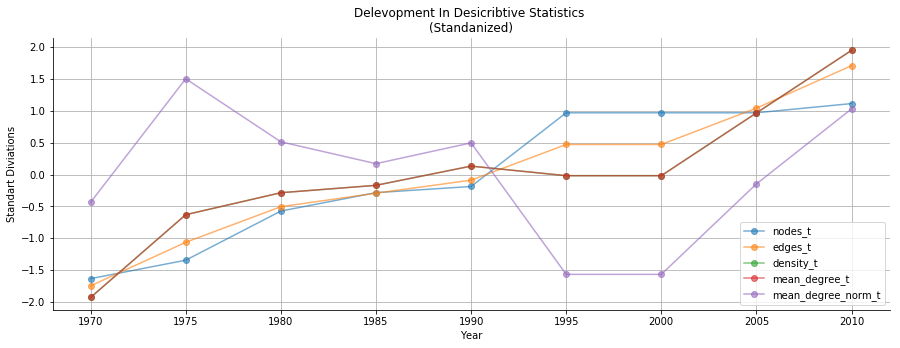

density and mean_degree overlaps perfectly


In [12]:
def time_plot():
    
    d_stats = get_d_stats()
    years = [1970, 1975, 1980, 1985, 1990, 1995, 2000, 2005, 2010]
    x = years

    plt.figure(figsize = [15,5])

    #for y in d_stats.values():

    for i in d_stats:
        y = d_stats[i]
        #plt.figure(figsize=(15,3))

        y_vec = np.array(y)

        #norm_y = (y_vec - y_vec.min())/(y_vec.max()-y_vec.min()) 
        std_y = (y_vec-y_vec.mean())/y_vec.std()  


        plt.plot(x, std_y, '-o', alpha = 0.6, label = i)

        plt.xlabel('Year')
        plt.ylabel('Standart Diviations')#right

        plt.title('Delevopment In Desicribtive Statistics \n(Standanized)')

        plt.legend()
        plt.grid()
        sns.despine()

    plt.show()
    
time_plot()

print('density and mean_degree overlaps perfectly') # Er det kosher? Og nå in and out mean er det samme så giver det ikke mening at dele op her.

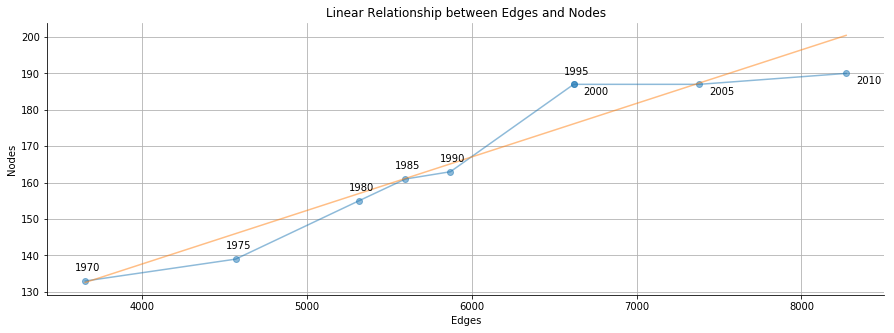

slope: 0.0147	intercept: 78.9	r²: 0.896	p_value: 0.000111	std_err: 0.00189


In [13]:
def lin_plot_e_n():

    d_stats = get_d_stats()
    years = [1970, 1975, 1980, 1985, 1990, 1995, 2000, 2005, 2010]
    labels = ['{}'.format(str(i)) for i in years]


    plt.figure(figsize=[15,5])

    x = np.array(d_stats['edges_t'])

    y = np.array(d_stats['nodes_t'])

    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    line = slope*x+intercept
    plt.plot(x,y,'-o', x, line, alpha = 0.5)
    
    #labels = years
    for label, x, y in zip(labels, x, y):
        if label in np.array(years[0:6]).astype('str'): # if statement to offset annotations and not clutter 1995 and 2000
            plt.annotate(label, xy=(x, y), xytext=(-10, 10), textcoords='offset points' ) #, ha='right', va='bottom')
            
        else:
            plt.annotate(label, xy=(x, y), xytext=(10, -10), textcoords='offset points' ) #, ha='right', va='bottom')

    
    
    plt.xlabel('Edges')
    plt.ylabel('Nodes')
    
    plt.title('Linear Relationship between Edges and Nodes')
    
    plt.grid()
    sns.despine()

    plt.show()

    print('slope: {:.3}\tintercept: {:.3}\tr²: {:.3}\tp_value: {:.3}\tstd_err: {:.3}'.format(slope, intercept, r_value**2, p_value, std_err))
    
lin_plot_e_n()
# men der sker jo faktisk lidt til sidst. Det kan man også se på det tidligere plot. Ikke flere nodes. men flere edges.

In [14]:
def degree_dist_plot(norm = True, kind = 'undirected'):
    
    years = [1970, 1975, 1980, 1985, 1990, 1995, 2000, 2005, 2010]
    colors = sns.palettes.color_palette(palette = "GnBu_d", n_colors = len(years))

    plt.figure(figsize=(15,5))

    for i in range(len(years)):

        year = str(years[i])
        graph_name = 'G_' + year
        color = colors[i]

        G = graphs[graph_name]
    
        if kind == 'undirected':
        
            raw_degree = G.degree
        
        elif kind == 'in':
            
            raw_degree = G.in_degree

        
        elif kind == 'out':

            raw_degree = G.out_degree

        
        else:
            print('unkown "kind"')
            
        degrees = np.array(list(dict(raw_degree).items()))[:,1].astype('float')
        degrees_norm = degrees / len(G.node)
        
        
        if norm == True:
        
            x = degrees_norm
            title = kind + '-Degree Ditribution\n Normalized'
        
        elif norm == False:
            
            x = degrees
            title = kind + '-Degree Ditribution\n Un-Normalized'

            
        else:
            
            print('wrong norm specification')
        
        
        sns.kdeplot(x, alpha = 0.6, label = graph_name,  color = color)

        
        plt.title(title)        

        maximum = max(x)
        minimum = 0  #np.min(count[0])

        plt.xlim(minimum,maximum) #burde automatiseres
        plt.xlabel('Degrees')

        #plt.ylim(0,maximum*1.1)
        plt.yticks([])

        plt.grid()
        sns.despine()
        #plt.legend()

    plt.show()
                                    


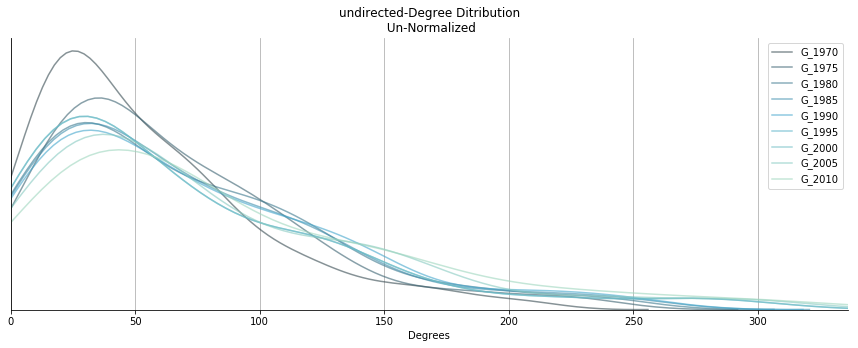

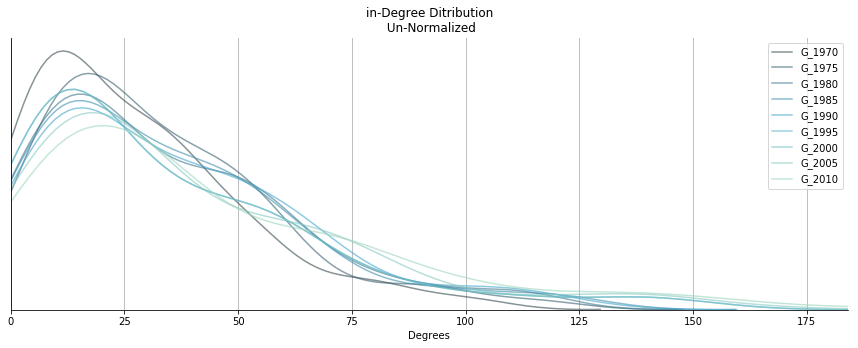

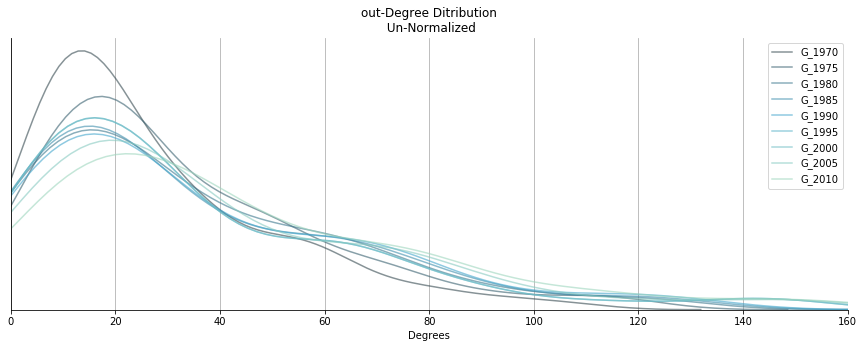

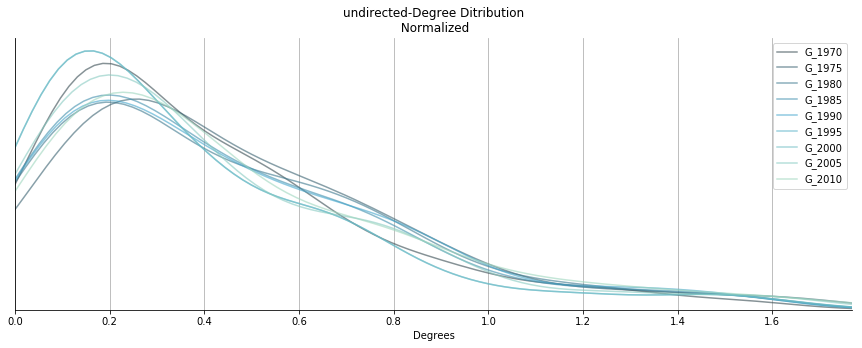

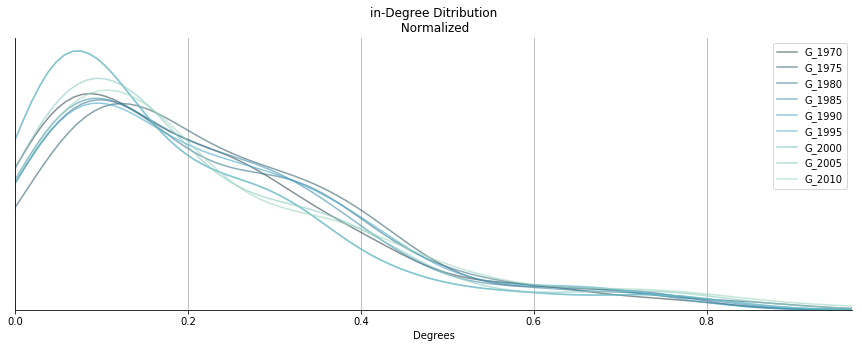

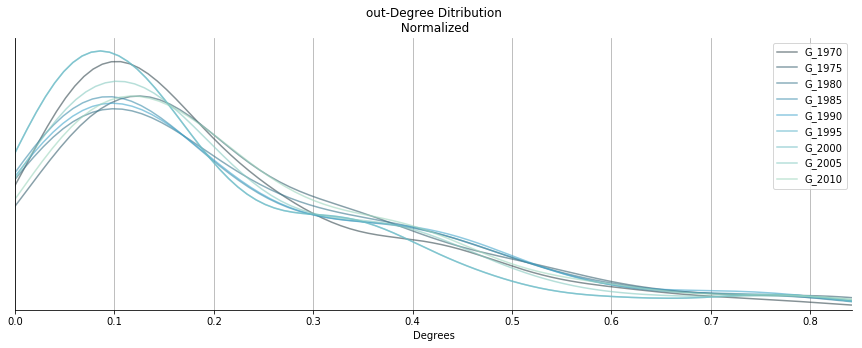

In [15]:
for i in [False,True]:
    for j in ['undirected', 'in' , 'out']:
        degree_dist_plot(i, j)

# Centralities

In [16]:
# men det er som om du har hentet de her informationer et par gange nu.... Kan du få denne her op tidligere og så bare bruge den?
# burde skfite all - ud med _...

def make_stats_df():

    full_df = pd.DataFrame()
    years = [1970, 1975, 1980, 1985, 1990, 1995, 2000, 2005, 2010]

    for i in range(len(years)):

        year = years[i]
        graph_name = 'G_' + str(year)

        G = graphs[graph_name]
        #nx.degree_centrality(G) #normalized

        DG = pd.DataFrame(pd.Series(dict(G.degree))).reset_index().rename(columns={'index': 'country', 0: 'degree'})
        in_DG = pd.DataFrame(pd.Series(dict(G.in_degree))).reset_index().rename(columns={'index': 'country', 0: 'in-degree'})
        out_DG = pd.DataFrame(pd.Series(dict(G.out_degree))).reset_index().rename(columns={'index': 'country', 0: 'out-degree'})
        
        
        DC = pd.DataFrame(pd.Series(nx.degree_centrality(G))).reset_index().rename(columns={'index': 'country', 0: 'degree_cent'})
        inDC = pd.DataFrame(pd.Series(nx.in_degree_centrality(G))).reset_index().rename(columns={'index': 'country', 0: 'in-degree_cent'})
        outDC = pd.DataFrame(pd.Series(nx.out_degree_centrality(G))).reset_index().rename(columns={'index': 'country', 0: 'out-degree_cent'})
        BC = pd.DataFrame(pd.Series(nx.betweenness_centrality(G))).reset_index().rename(columns={'index': 'country', 0: 'betweenness_cent'})
        #IC = pd.DataFrame(pd.Series(nx.information_centrality(G))).reset_index().rename(columns={'index': 'rep', 0: 'information_cent'})

        net_stats = DG.merge(in_DG, how = 'outer')
        net_stats = net_stats.merge(out_DG, how = 'outer')
        net_stats = net_stats.merge(DC, how = 'outer')
        net_stats = net_stats.merge(inDC, how = 'outer')
        net_stats = net_stats.merge(outDC, how = 'outer')
        net_stats = net_stats.merge(BC, how = 'outer')

        net_stats['year'] = year

        #net_stats = net_stats.merge(COM)
        #net_stats.sample(6)

        full_df = pd.concat([full_df,net_stats])
        
    return(full_df)

stats_df = make_stats_df()

In [17]:
stats_df.sort_values('betweenness_cent', ascending=False).head(6)

,country,degree,in-degree,out-degree,degree_cent,in-degree_cent,out-degree_cent,betweenness_cent,year
0,USA,307,156,151,1.650538,0.838710,0.811828,0.123707,1995
0,USA,307,156,151,1.650538,0.838710,0.811828,0.123707,2000
0,USA,198,103,95,1.500000,0.780303,0.719697,0.115272,1970
0,USA,316,166,150,1.698925,0.892473,0.806452,0.112115,2005
0,USA,233,119,114,1.688406,0.862319,0.826087,0.109503,1975
25,UKG,224,114,110,1.623188,0.826087,0.797101,0.108262,1975


In [18]:
stats_df.sort_values('in-degree_cent', ascending=False).head(6)

,country,degree,in-degree,out-degree,degree_cent,in-degree_cent,out-degree_cent,betweenness_cent,year
0,USA,336,184,152,1.777778,0.973545,0.804233,0.105156,2010
0,USA,316,166,150,1.698925,0.892473,0.806452,0.112115,2005
27,BEL,248,163,85,1.312169,0.862434,0.449735,0.028364,2010
0,USA,233,119,114,1.688406,0.862319,0.826087,0.109503,1975
0,USA,307,156,151,1.650538,0.838710,0.811828,0.123707,1995
0,USA,307,156,151,1.650538,0.838710,0.811828,0.123707,2000


In [19]:
stats_df.sort_values('out-degree_cent', ascending=False).head(6)

,country,degree,in-degree,out-degree,degree_cent,in-degree_cent,out-degree_cent,betweenness_cent,year
30,FRN,223,103,120,1.615942,0.746377,0.869565,0.071315,1975
125,CHN,318,158,160,1.682540,0.835979,0.846561,0.081851,2010
126,CHN,300,143,157,1.612903,0.768817,0.844086,0.083646,2005
31,FRN,252,118,134,1.555556,0.728395,0.827160,0.062107,1990
0,USA,233,119,114,1.688406,0.862319,0.826087,0.109503,1975
28,FRN,303,147,156,1.603175,0.777778,0.825397,0.047115,2010


In [20]:
def df_dist_plot(col = 'betweenness_cent'):
    
    years = stats_df['year'].unique()
    colors = sns.palettes.color_palette(palette = "GnBu_d", n_colors = len(years))

    plt.figure(figsize=(15,5))

    for i in range(len(years)):

        year = years[i]
        subset = stats_df[stats_df['year']==year]
        graph_name = 'G_' + str(year)
        
        color = colors[i]
                  
        x = subset[col]
        
        sns.kdeplot(x, alpha = 0.6, label = graph_name,  color = color)

        
        plt.title(col)        

        maximum = max(x)
        minimum = 0  #np.min(count[0])

        plt.xlim(minimum,maximum) #burde automatiseres
        #plt.xlabel(col)

        #plt.ylim(0,maximum*1.1)
        plt.yticks([])

        plt.grid()
        sns.despine()
        #plt.legend()

    plt.show()
                                    


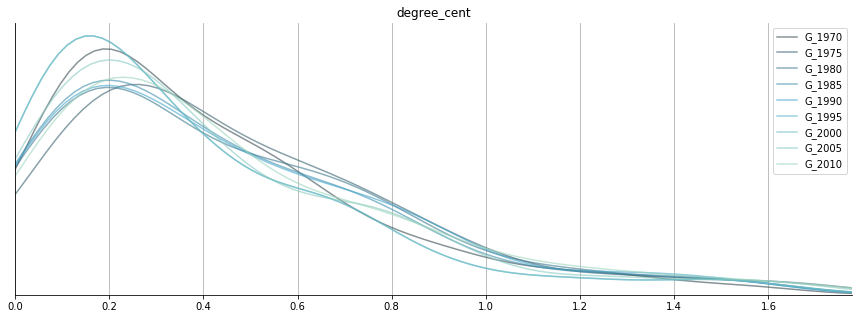

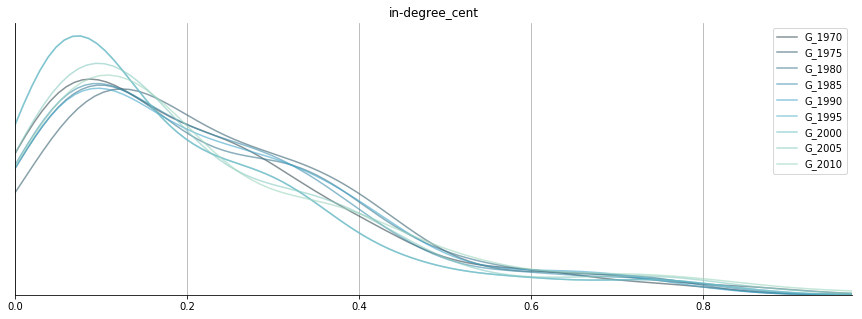

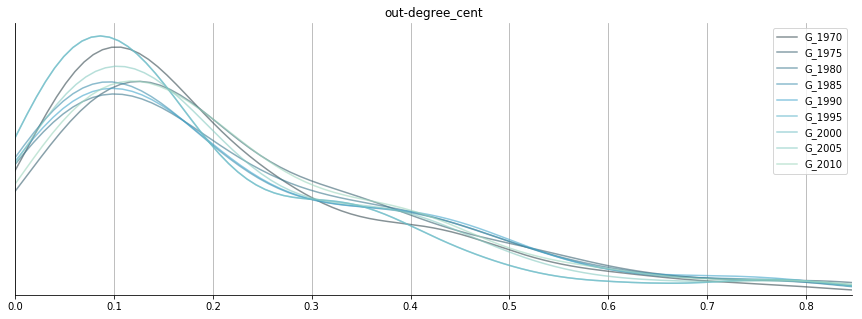

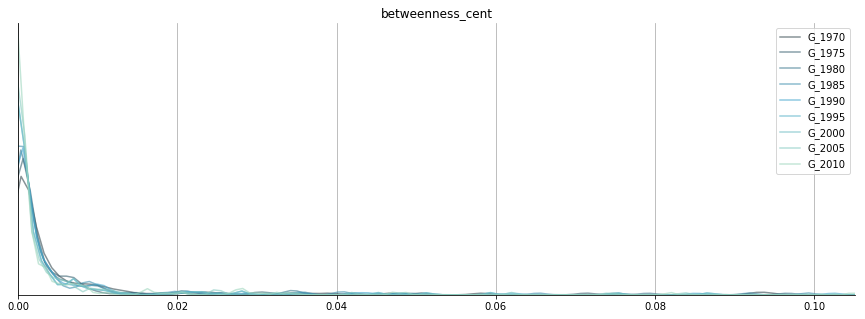

In [21]:
for i in ['degree_cent','in-degree_cent','out-degree_cent','betweenness_cent']:
    col = i
    df_dist_plot(col)

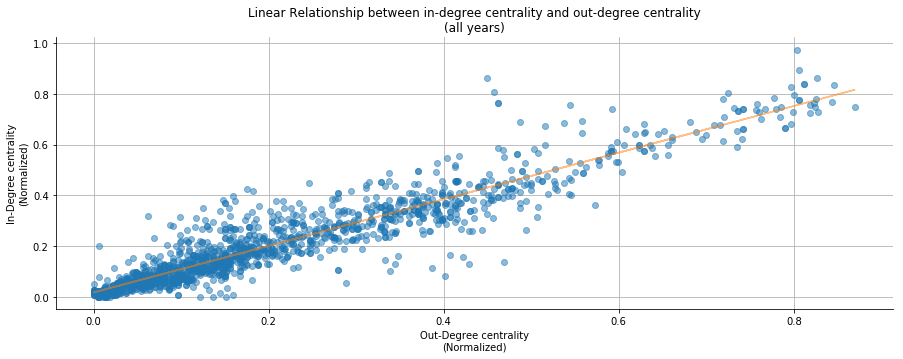

slope: 0.918	intercept: 0.0176	r²: 0.877	p_value: 0.0	std_err: 0.00887


In [22]:
def lin_plot_in_out():

#     d_stats = get_d_stats()
#     years = [1970, 1975, 1980, 1985, 1990, 1995, 2000, 2005, 2010]
#     labels = ['{}'.format(str(i)) for i in years]


    plt.figure(figsize=[15,5])

    x = stats_df['out-degree_cent']

    y = stats_df['in-degree_cent']

    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    line = slope*x+intercept
    plt.plot(x,y,'o', x, line, alpha = 0.5)
    
#     #labels = years
#     for label, x, y in zip(labels, x, y):
#         if label in np.array(years[0:6]).astype('str'): # if statement to offset annotations and not clutter 1995 and 2000
#             plt.annotate(label, xy=(x, y), xytext=(-10, 10), textcoords='offset points' ) #, ha='right', va='bottom')
            
#         else:
#             plt.annotate(label, xy=(x, y), xytext=(10, -10), textcoords='offset points' ) #, ha='right', va='bottom')

    
    
    plt.xlabel('Out-Degree centrality\n(Normalized)')
    plt.ylabel('In-Degree centrality\n(Normalized)')
    
    plt.title('Linear Relationship between in-degree centrality and out-degree centrality\n(all years)')
    
    plt.grid()
    sns.despine()

    plt.show()

    print('slope: {:.3}\tintercept: {:.3}\tr²: {:.3}\tp_value: {:.3}\tstd_err: {:.3}'.format(slope, intercept, r_value**2, p_value, std_err))
    
lin_plot_in_out()

Hvem er de tre de stikker lidt ud?

Så det ville være ret hvis in og out sagde to forskellige ting: ud = power, ind = oppotunities. Men det er tvivlsomt.

På den anden side måske netop diskrepansen kan sige noget?

In [23]:
# diskrepans:

stats_df['out_ratio'] = stats_df['out-degree'] / stats_df['degree']
stats_df['in_ratio'] = stats_df['in-degree'] / stats_df['degree']


#stats_df['out_cent_ratio'] = stats_df['out-degree_cent'] / stats_df['degree_cent'] # Er helt det samme som overstående
#stats_df['in_cent_ratio'] = stats_df['in-degree_cent'] / stats_df['degree_cent'] #  Er helt det samme som overstående


In [24]:
# make a function...

degree_set_1970 = set(stats_df[stats_df['year'] == 1970].sort_values('degree_cent', ascending = False).head(10)['country'])
between_set_1970 = set(stats_df[stats_df['year'] == 1970].sort_values('betweenness_cent', ascending = False).head(10)['country'])

power_set_1970  = set.intersection(degree_set_1970, between_set_1970)

power_set_1970

{'BEL', 'EGY', 'FRN', 'GFR', 'IND', 'ITA', 'JPN', 'RUS', 'UKG', 'USA'}

In [25]:
# ma

degree_set_2010 = set(stats_df[stats_df['year'] == 2010].sort_values('degree_cent', ascending = False).head(10)['country'])
between_set_2010 = set(stats_df[stats_df['year'] == 2010].sort_values('betweenness_cent', ascending = False).head(10)['country'])

power_set_2010  = set.intersection(degree_set_2010, between_set_2010)

power_set_2010

{'BEL', 'CHN', 'FRN', 'GMY', 'IND', 'JPN', 'RUS', 'UKG', 'USA'}

In [26]:
# MAKE SOME FUNCTION -----------------------------------------------------------------------------------------------------------

degree_set_1970 = set(stats_df[stats_df['year'] == 1970].sort_values('degree_cent', ascending = False).head(10)['country'])
between_set_1970 = set(stats_df[stats_df['year'] == 1970].sort_values('betweenness_cent', ascending = False).head(10)['country'])

power_set_1970  = set.intersection(degree_set_1970, between_set_1970)

power_df_1970 = stats_df[stats_df['country'].isin(power_set_1970)]

degree_set_2010 = set(stats_df[stats_df['year'] == 2010].sort_values('degree_cent', ascending = False).head(10)['country'])
between_set_2010 = set(stats_df[stats_df['year'] == 2010].sort_values('betweenness_cent', ascending = False).head(10)['country'])

power_set_2010  = set.intersection(degree_set_2010, between_set_2010)

power_df_2010 = stats_df[stats_df['country'].isin(power_set_2010)]
power_df_2010.head()
# ------

,country,degree,in-degree,out-degree,degree_cent,in-degree_cent,out-degree_cent,betweenness_cent,year,out_ratio,in_ratio
0,USA,198,103,95,1.500000,0.780303,0.719697,0.115272,1970,0.479798,0.520202
23,BEL,142,75,67,1.075758,0.568182,0.507576,0.024562,1970,0.471831,0.528169
25,FRN,208,100,108,1.575758,0.757576,0.818182,0.094143,1970,0.519231,0.480769
84,JPN,147,71,76,1.113636,0.537879,0.575758,0.020962,1970,0.517007,0.482993
85,IND,129,66,63,0.977273,0.500000,0.477273,0.023010,1970,0.488372,0.511628


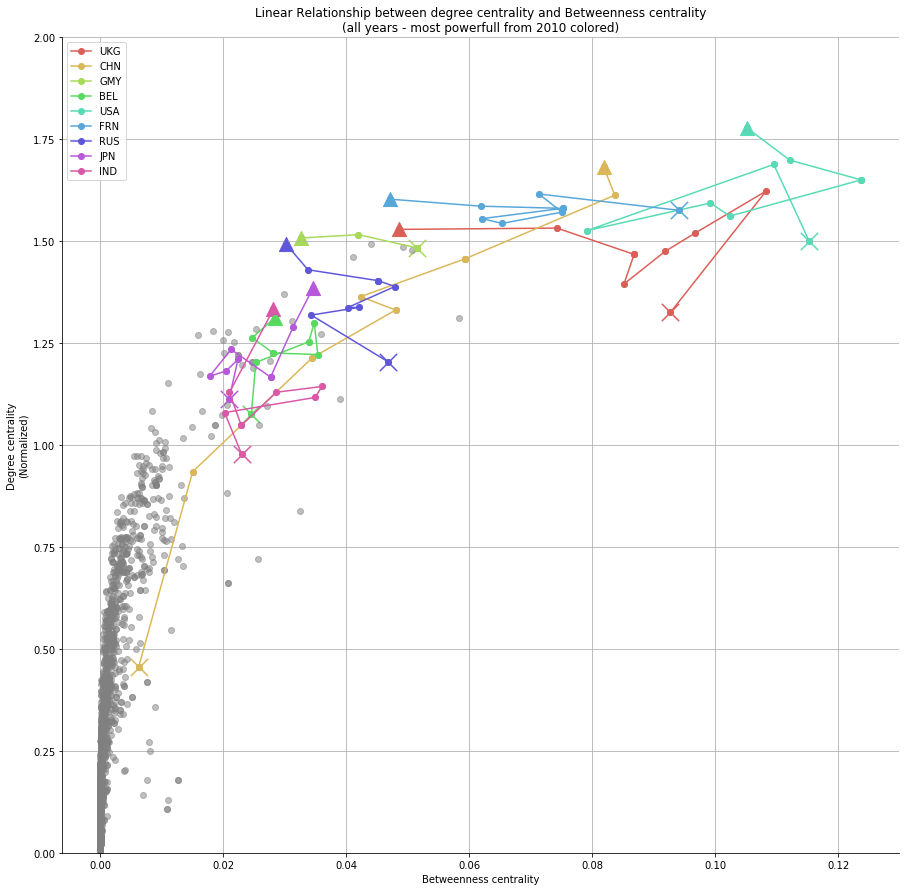

In [27]:
# MAKE SOME FUNCTION -----------------------------------------------------------------------------------------------------------

degree_set_1970 = set(stats_df[stats_df['year'] == 1970].sort_values('degree_cent', ascending = False).head(10)['country'])
between_set_1970 = set(stats_df[stats_df['year'] == 1970].sort_values('betweenness_cent', ascending = False).head(10)['country'])

power_set_1970  = set.intersection(degree_set_1970, between_set_1970)

power_df_1970 = stats_df[stats_df['country'].isin(power_set_1970)]

degree_set_2010 = set(stats_df[stats_df['year'] == 2010].sort_values('degree_cent', ascending = False).head(10)['country'])
between_set_2010 = set(stats_df[stats_df['year'] == 2010].sort_values('betweenness_cent', ascending = False).head(10)['country'])

power_set_2010  = set.intersection(degree_set_2010, between_set_2010)

power_df_2010 = stats_df[stats_df['country'].isin(power_set_2010)]

# -----------------------------------------------------------------------------------------------------------------------------------


def plot_b_d():

#     d_stats = get_d_stats()
#     years = [1970, 1975, 1980, 1985, 1990, 1995, 2000, 2005, 2010]
#     labels = ['{}'.format(str(i)) for i in years]


    plt.figure(figsize=[15,15])
    
    
    x = stats_df['betweenness_cent']
    #x_power_sub_1970 = stats_df[stats_df['country'].isin(power_set_1970)]['betweenness_cent']
    #x_power_sub_2010 = stats_df[stats_df['country'].isin(power_set_2010)]['betweenness_cent']

    y = stats_df['degree_cent']
    #y_power_sub_1970 = stats_df[stats_df['country'].isin(power_set_1970)]['degree_cent']
    #y_power_sub_2010 = stats_df[stats_df['country'].isin(power_set_2010)]['degree_cent']

    #slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    #line = slope*x+intercept
    
    #exp_line = sorted(0.39288364 * np.exp(-15.55155634*x))
    
    #log_line = sorted(1+np.log(line)) # + np.abs(min(np.log(line))))
    
#     def f(x, a, b, c):
#         return a*np.exp(-b*x) + c
    
    #exp_line = sorted(f(x,-1.6, 85, 1.6)) # de her tal skal du havde fittet ordenligt..
    #x_sorted = sorted(x)
    
    #wierd_line = (np.array(log_line)+np.array(exp_line))/2 # actually not that bad..
    
    plt.plot(x,y,'o', alpha = 0.5, label = '', color = 'grey')
    #plt.plot(x_sorted, exp_line, label = 'exp func', alpha = 0.2)
    
    colors = sns.palettes.color_palette(palette = "hls", n_colors = len(power_set_2010))
    
    # power_players:
    for i in range(len(power_set_2010)):
        
            x_sub = power_df_2010[power_df_2010['country']==list(power_set_2010)[i]].sort_values('year')['betweenness_cent']
            y_sub = power_df_2010[power_df_2010['country']==list(power_set_2010)[i]].sort_values('year')['degree_cent']
            
            label = list(power_set_2010)[i]
        
            plt.plot(x_sub,y_sub, '-o', label = label, color=colors[i])#,  s=200+j*100, facecolors='none', edgecolors=my_colors2[j], label = labels2[j])
    
    
    # Start_poin for power_players:
    
    for i in range(len(power_set_2010)):
        
            start_year = power_df_2010[power_df_2010['country']==list(power_set_2010)[i]]['year'].min()
            end_year =  power_df_2010[power_df_2010['country']==list(power_set_2010)[i]]['year'].max()
        
            x_start = power_df_2010[(power_df_2010['country']==list(power_set_2010)[i]) & (power_df_2010['year'] == start_year)]['betweenness_cent']
            y_start = power_df_2010[(power_df_2010['country']==list(power_set_2010)[i]) & (power_df_2010['year'] == start_year)]['degree_cent']
            
            x_end = power_df_2010[(power_df_2010['country']==list(power_set_2010)[i]) & (power_df_2010['year'] == end_year)]['betweenness_cent']
            y_end = power_df_2010[(power_df_2010['country']==list(power_set_2010)[i]) & (power_df_2010['year'] == end_year)]['degree_cent']
            
            #label = list(power_set_2010)[i]
        
            plt.scatter(x_start,y_start, marker = 'x', label = '', color=colors[i], s = 300)#,  s=200+j*100, facecolors='none', edgecolors=my_colors2[j], label = labels2[j])
            plt.scatter(x_end,y_end, marker = '^', label = '', color=colors[i], s = 200)#,  s=200+j*100, facecolors='none', edgecolors=my_colors2[j], label = labels2[j])

    
    
    
    
#     #labels = years
#     for label, x, y in zip(labels, x, y):
#         if label in np.array(years[0:6]).astype('str'): # if statement to offset annotations and not clutter 1995 and 2000
#             plt.annotate(label, xy=(x, y), xytext=(-10, 10), textcoords='offset points' ) #, ha='right', va='bottom')
            
#         else:
#             plt.annotate(label, xy=(x, y), xytext=(10, -10), textcoords='offset points' ) #, ha='right', va='bottom')

    
    
    plt.xlabel('Betweenness centrality')
    plt.ylabel('Degree centrality\n(Normalized)')
    
    plt.ylim(0,2)
    
    plt.title('Linear Relationship between degree centrality and Betweenness centrality\n(all years - most powerfull from 2010 colored)')
    
    plt.grid()
    sns.despine()

    plt.legend()
    
    plt.show()

    #print('slope: {:.3}\tintercept: {:.3}\tr²: {:.3}\tp_value: {:.3}\tstd_err: {:.3}'.format(slope, intercept, r_value**2, p_value, std_err))
    
plot_b_d()

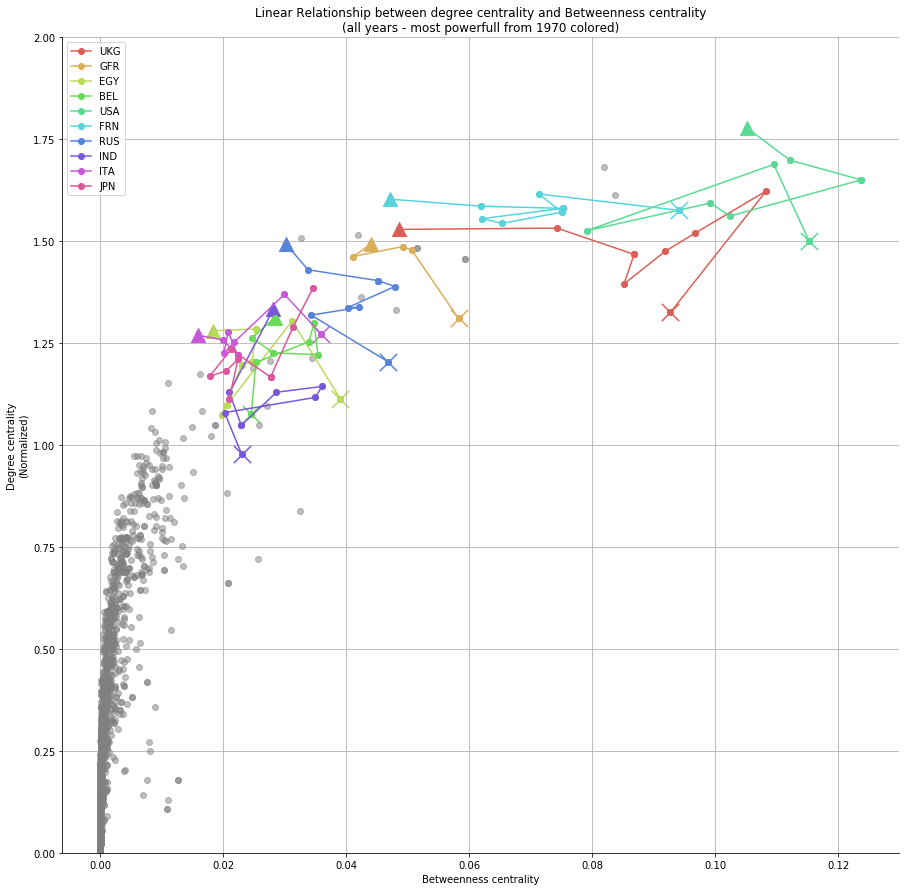

In [28]:
# MAKE SOME FUNCTION -----------------------------------------------------------------------------------------------------------

degree_set_1970 = set(stats_df[stats_df['year'] == 1970].sort_values('degree_cent', ascending = False).head(10)['country'])
between_set_1970 = set(stats_df[stats_df['year'] == 1970].sort_values('betweenness_cent', ascending = False).head(10)['country'])

power_set_1970  = set.intersection(degree_set_1970, between_set_1970)

power_df_1970 = stats_df[stats_df['country'].isin(power_set_1970)]

degree_set_2010 = set(stats_df[stats_df['year'] == 2010].sort_values('degree_cent', ascending = False).head(10)['country'])
between_set_2010 = set(stats_df[stats_df['year'] == 2010].sort_values('betweenness_cent', ascending = False).head(10)['country'])

power_set_2010  = set.intersection(degree_set_2010, between_set_2010)

power_df_2010 = stats_df[stats_df['country'].isin(power_set_2010)]

# -----------------------------------------------------------------------------------------------------------------------------------
# Du burde kunne smide det her sammen med overstående..

def plot_b_d2():

#     d_stats = get_d_stats()
#     years = [1970, 1975, 1980, 1985, 1990, 1995, 2000, 2005, 2010]
#     labels = ['{}'.format(str(i)) for i in years]


    plt.figure(figsize=[15,15])
    
    
    x = stats_df['betweenness_cent']
    #x_power_sub_1970 = stats_df[stats_df['country'].isin(power_set_1970)]['betweenness_cent']
    #x_power_sub_2010 = stats_df[stats_df['country'].isin(power_set_2010)]['betweenness_cent']

    y = stats_df['degree_cent']
    #y_power_sub_1970 = stats_df[stats_df['country'].isin(power_set_1970)]['degree_cent']
    #y_power_sub_2010 = stats_df[stats_df['country'].isin(power_set_2010)]['degree_cent']

    #slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    #line = slope*x+intercept
    
    #exp_line = sorted(0.39288364 * np.exp(-15.55155634*x))
    
    #log_line = sorted(1+np.log(line)) # + np.abs(min(np.log(line))))
    
#     def f(x, a, b, c):
#         return a*np.exp(-b*x) + c
    
    #exp_line = sorted(f(x,-1.6, 85, 1.6)) # de her tal skal du havde fittet ordenligt..
    #x_sorted = sorted(x)
    
    #wierd_line = (np.array(log_line)+np.array(exp_line))/2 # actually not that bad..
    
    plt.plot(x,y,'o', alpha = 0.5, label = '', color = 'grey')
    #plt.plot(x_sorted, exp_line, label = 'exp func', alpha = 0.2)
    
    colors = sns.palettes.color_palette(palette = "hls", n_colors = len(power_set_1970))
    
    # power_players:
    for i in range(len(power_set_1970)):
        
            x_sub = power_df_1970[power_df_1970['country']==list(power_set_1970)[i]].sort_values('year')['betweenness_cent']
            y_sub = power_df_1970[power_df_1970['country']==list(power_set_1970)[i]].sort_values('year')['degree_cent']
            
            label = list(power_set_1970)[i]
        
            plt.plot(x_sub,y_sub, '-o', label = label, color=colors[i])#,  s=200+j*100, facecolors='none', edgecolors=my_colors2[j], label = labels2[j])
    
    
    # Start_poin for power_players:
    
    for i in range(len(power_set_2010)):
        
            start_year = power_df_1970[power_df_1970['country']==list(power_set_1970)[i]]['year'].min()
            end_year =  power_df_1970[power_df_1970['country']==list(power_set_1970)[i]]['year'].max()
        
            x_start = power_df_1970[(power_df_1970['country']==list(power_set_1970)[i]) & (power_df_1970['year'] == start_year)]['betweenness_cent']
            y_start = power_df_1970[(power_df_1970['country']==list(power_set_1970)[i]) & (power_df_1970['year'] == start_year)]['degree_cent']
            
            x_end = power_df_1970[(power_df_1970['country']==list(power_set_1970)[i]) & (power_df_1970['year'] == end_year)]['betweenness_cent']
            y_end = power_df_1970[(power_df_1970['country']==list(power_set_1970)[i]) & (power_df_1970['year'] == end_year)]['degree_cent']
            
            #label = list(power_set_2010)[i]
        
            plt.scatter(x_start,y_start, marker = 'x', label = '', color=colors[i], s = 300)#,  s=200+j*100, facecolors='none', edgecolors=my_colors2[j], label = labels2[j])
            plt.scatter(x_end,y_end, marker = '^', label = '', color=colors[i], s = 200)#,  s=200+j*100, facecolors='none', edgecolors=my_colors2[j], label = labels2[j])

    
    
    
    
#     #labels = years
#     for label, x, y in zip(labels, x, y):
#         if label in np.array(years[0:6]).astype('str'): # if statement to offset annotations and not clutter 1995 and 2000
#             plt.annotate(label, xy=(x, y), xytext=(-10, 10), textcoords='offset points' ) #, ha='right', va='bottom')
            
#         else:
#             plt.annotate(label, xy=(x, y), xytext=(10, -10), textcoords='offset points' ) #, ha='right', va='bottom')

    
    
    plt.xlabel('Betweenness centrality')
    plt.ylabel('Degree centrality\n(Normalized)')
    
    plt.ylim(0,2)
    
    plt.title('Linear Relationship between degree centrality and Betweenness centrality\n(all years - most powerfull from 1970 colored)')
    
    plt.grid()
    sns.despine()

    plt.legend()
    
    plt.show()

    #print('slope: {:.3}\tintercept: {:.3}\tr²: {:.3}\tp_value: {:.3}\tstd_err: {:.3}'.format(slope, intercept, r_value**2, p_value, std_err))
    
plot_b_d2()

### Proof of concept...
kunne også bare fitte en gaussian porcess...

In [29]:
import scipy

a = -2.464033130646042	b = 8.263997893297875	c = 0.21816611698503457


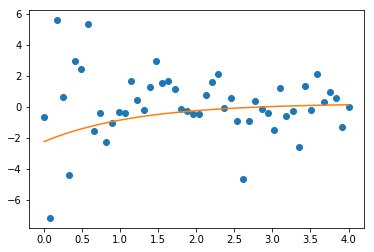

In [30]:
# Eks på exponential fit.

# x = stats_df['betweenness_cent']
# y = stats_df['degree_cent']

def f(x, a, b, c):
    return a*np.exp(-b*x) + c


x = np.linspace(0,4,50)
y = f(x,2.5,1.3,0.5) * 2*np.random.normal(size=len(x))

params, extras = scipy.optimize.curve_fit(f, x, y)

print('a = {}\tb = {}\tc = {}'.format(params[0], params[1], params[2]))


plt.plot(x,y,'o')
plt.plot(x, f(x,params[0],params[1]*0.1,params[2]))
plt.show()

a = 127.61940099399474	b = -1.872975045582411	c = -125.99342477193315


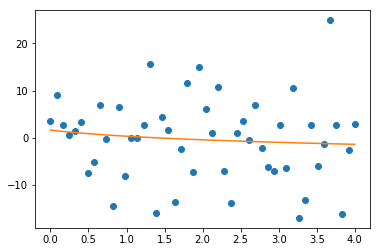

In [31]:
# Eks på log fit.

# x = stats_df['betweenness_cent']
# y = stats_df['degree_cent']

def f(x, a, b, c):
    return a+b*np.log(x+1) + c


x = np.linspace(0,4,50)
y = f(x,2.5,1.3,0.5) * 2*np.random.normal(size=len(x))

params, extras = scipy.optimize.curve_fit(f, x, y)

print('a = {}\tb = {}\tc = {}'.format(params[0], params[1], params[2]))


plt.plot(x,y,'o')
plt.plot(x, f(x,params[0],params[1],params[2]))
plt.show()

# Draw graph

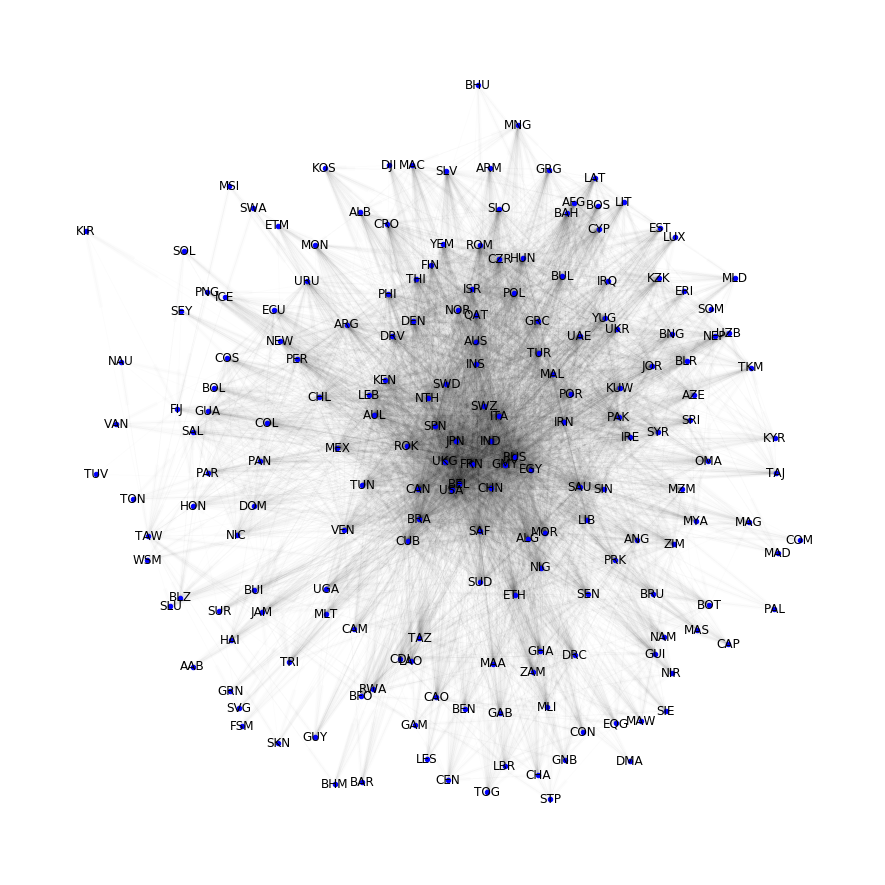

In [32]:
plt.axes([2,3,2,3])

G = graphs['G_2010']

pos = graphviz_layout(G)

nx.draw_networkx_edges(G, alpha = 0.01, pos=pos)
nx.draw_networkx_nodes(G, font_size=8, node_size=20, pos=pos, node_color="blue") #, nodelist=R_nodes , node_size=20, node_color="red", alpha = 0.6, pos=pos, label = "Republicans", fontsize = 16)
nx.draw_networkx_labels(G, pos = pos)

#nx.draw(G, alpha = 0.5, pos=pos,  with_labels=True)

sns.despine(left=True, bottom=True)

plt.xticks(())
plt.yticks(())

plt.show()

# fint, men ta' det ovet i gephi
#nx.write_gexf(G, "dipcon_net_2010.gexf", version="1.2draft")

